<a href="https://colab.research.google.com/github/Ahtesham519/Genrative_Deep_learning_v2_2023/blob/main/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (

                              layers,
                              models,
                              datasets,
                              callbacks,
                              losses,
                              optimizers,
                              metrics,
)

from scipy.stats import norm



# 0.Parameters

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDINGS_DIM = 2
EPOCHS = 5
BETA = 500



### 1. Prepare *Data*

In [3]:
#Load the data
(x_train, y_train ), (x_test, y_test) = datasets.fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


In [4]:
#Prepare the data

def preprocess(imgs):
  """
  normalize and reshape the images.
  """

  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs , ((0,0) , (2,2) , (2,2)), constant_values = 0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

  x_trian = preprocess(x_train)
  x_test = preprocess(x_test)

In [5]:
#Show some items of clothings from the training set
display(x_train , y_train)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

# 2.Build the variational autoencoder

In [6]:
class Sampling(layers.Layer):
  def call(self,inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim ))
    return z_mean +tf.exp(0.5 * z_log_var) * epsilon

In [7]:
#encoder

encoder_input = layers.Input(
    shape= (IMAGE_SIZE , IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32,(3,3), strides = 2, activation = "relu" , padding = "same")(
    encoder_input
)
x = layers.Conv2D(64,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(128, (3,3) , strides = 2, activation = "relu", padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]  #the decoder will need this!

x= layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDINGS_DIM , name = "z_mean")(x)
z_log_var = layers.Dense(EMBEDDINGS_DIM,name="z_log_var")(x)
z = Sampling()([z_mean , z_log_var])

encoder = models.Model(encoder_input, [z_mean,z_log_var, z] , name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [8]:
#Decoder
decoder_input = layers.Input(shape = (EMBEDDINGS_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)
x = layers.Conv2DTranspose(
    64, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)
decoder_output = layers.Conv2D(
    32,(3,3), strides = 2, activation = "relu", padding = "same"
)(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides = 1,
    activation = "sigmoid",
    padding = "same",
    name = "decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()
















Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2D)     (None, 16, 16, 1)         577   

In [12]:
class VAE(models.Model):
  def __init___(self, encoder, decoder, **kwargs):
    super(VAE,self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name = "total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(
        name="reconstruction_loss")
    self.k1_loss_tracker = metrics.Mean(name= "k1_loss")


    @property
    def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.k1_loss_tracker,
      ]

    def call(self, inputs):
      """
      call the model on the particular input
      """
      z_mean, z_log_var , z = encoder(inputs)
      reconstruction = decoder(z)
      return z_mean , z_log_var ,reconstruction

    def train_step(self,data):
      """ Step run during training."""
      with tf.GradientTape() as tape :
        z_mean , z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(
                data, reconstruction, axis=(1,2,3)
            )
        )
        k1_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5
                *(1+ z_log_var - tf.square(z_mean) . tf.exp(z_log_var)),
                axis = 1,
            )
        )
        total_loss = reconstruction_loss + k1_loss
    grads = tape.gradient(total_loss, self .trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.k1_loss_tracker.update_state(k1_loss)

    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    """ Step run during validation."""
    if isinstance(data, tuple):
      data= data[0]

    z_mean, z_log_var , reconstruction = self(data)
    reconstruction_loss = tf.reduce_mean(
        BETA
        * losses.binary_crossentropy(data, reconstruction , axis= (1,2,3))
    )
    k1_loss = tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 +z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
            axis = 1,
        )
    )
    total_loss = reconstruction_loss + k1_loss

    return {
        "loss" : total_loss,
        "reconstruction_loss" : reconstruction_loss,
        "k1_loss" : k1_loss,
    }

In [13]:
#Create a variational autoencoder
vae = VAE(encoder, decoder)

ValueError: ignored

## 3. Train the variational autoencoder

In [14]:
#complie the variational autoencoder
optimizer = optimizers.Adam(learning_rate = 0.0005)
vae.compile(optomizer = optimizer)

NameError: ignored

In [15]:
#Create a model save it to a checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = "./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir = "./logs")


In [16]:
vae.fit(
    x_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = True,
    validation_data = (x_test , x_test),
    callbacks = [model_checkpoint_callback , tensorboard_callback]
)


NameError: ignored

In [17]:
#Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

NameError: ignored

### 3.Recontruct using the variational autoencoder

In [18]:
#select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [19]:
#Create autoencoder predictions and display
z_mean , z_log_var , reconstructions = vae.predict(example_images)
print("Example real clothings items")
display(example_images)
print("reconstructions")
display(reconstructions)

NameError: ignored

## 4. Embed using the encoder

In [20]:
#encode the example images
z_mean , z_var , z = encoder.predict(example_images)



ValueError: ignored

In [21]:
#some examples of the embeddings
print(z[:10])


KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


TypeError: ignored

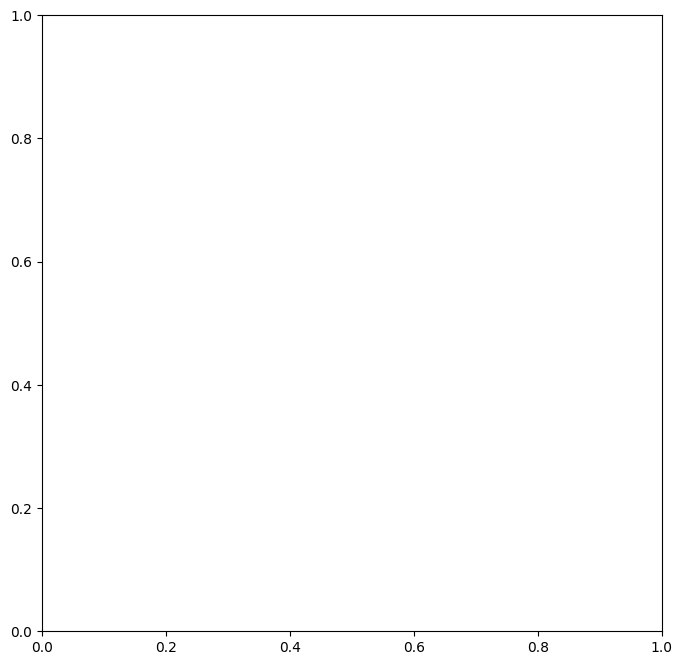

In [22]:
#Show the encoded points in 2D space
figsize = 8

plt.figure(figsize =(figsize , figsize))
plt.scatter(z[:,0] , z[:, 1], c="black" , alpha=0.5, s= 3)
plt.show()

## 5.Generate using the decoder

In [23]:
#Sampel , some points in the latent space , from the standrad normal distributation
grid_width , grid_height = (6,3)
z_sample = np.random.normal(size = (grid_width * grid_height, 2))

In [24]:
#Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 317ms/step


In [25]:
#Convert orignal embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)


TypeError: ignored

TypeError: ignored

/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in double_scalars
  x1 = self.convert_xunits(self._x0 + self._width)
/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)


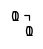

In [26]:
#Draw a plot of....
figsize = 0
plt.figure(figsize = (figsize, figsize))

#the orginal embeddings
plt.scatter(z[:,0], z[:,1], c="black" , alpha = 0.5, s= 2)

#...and the newley genrated points in the latent space
plt.scatter(z_sample[:,0] , z_sample[:,1] , c="#00B0F0", alpha = 1, s = 40)
plt.show()

#add inderneath a grid of the decode images
fig = plt.figure(figsize = (figsize, grid_height * 2))
fig.subplots_adjust(hspace =0.4, wspace = 0.4)

for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i +1)
  ax.axis("off")
  ax.text(
      0.5,
      -0.35,
      str(np.round(z_sample[i, :], 1)),
      fontsize = 10,
      ha = "center",
      transform = ax.transAxes,
  )
  ax.imshow(reconstruction[i,:,:] , cmap = "Greys")

### 6.Explore the latent space

TypeError: ignored

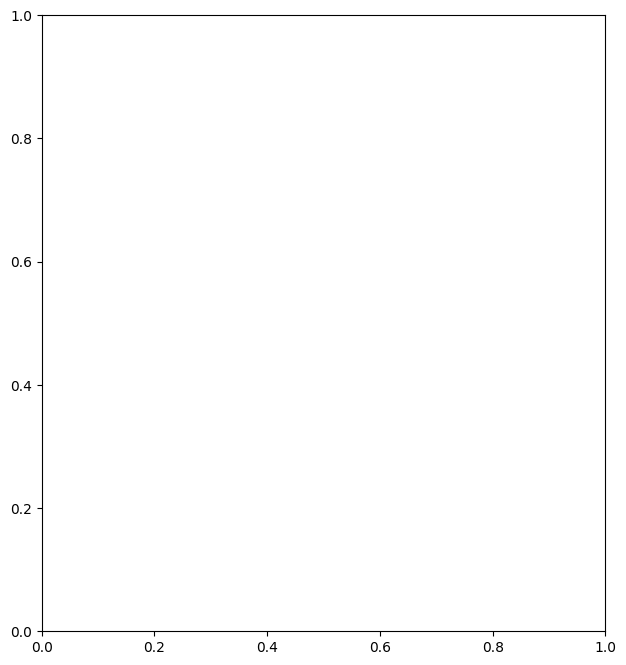

In [27]:
#color the embeddings by their label (clothing type - see table)

figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1,2,1)
plot_1 = ax.scatter(
    z[:,0], z[:,1], cmap="rainbow", c = example_labels, alpha = 0.8, s =3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1,2,2)
plot_2 = ax.scatter(
    p[:,0] , p[:, 1], cmap = "rainbow", c = example_labels,alpha = 0.8 , s = 3
)
plt.show()

In [30]:
#Color the embeddings by their labels (clothings type - see tabel)

figsize = 12
grid_size = 15
plt.figure(figsize = (figsize, figsize))
plt.scatter(
    p[:, 0 ], p[:,1], cmap = "rainbow", c= example_labels, aplha=0.8, s = 300
)
plt.colorbar()

x= norm.ppf(np.linspace(0,1,grid_size))
y = norm.ppf(nplinsace(1,0,grid_size))
xv, yv = np.meshgrid(x,y)

xv = xv.flatten()
yv = yv.flatter()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
plt.show()

fig = plt.figure(figsize = (figsize, figsize))
fig.subplots_adjust(hspace= 0.4 , wspace = 0.4)
for i in range(grid_size ** 2):
  ax = fig.add_subplot(grid_size, grid_size , i +1)
  ax.axis("off")
  ax.imshow(reconstruction[i, :, :], cmap = "Greys")


NameError: ignored

<Figure size 1200x1200 with 0 Axes>